### Tested Idea: image encoding via piecewise polynomials

Use qsp_main6

In [6]:
from matplotlib import pyplot as plt
import pickle as pkl

import quimb.tensor as qtn

from qsp.misc_states import make_aklt_mps
from qsp.misc_states import make_aklt_peps
from qsp.tsp import MPSPreparation, PEPSPreparation
from qsp.tsp_helper_routines import make_splitted_mps

from qiskit import Aer, execute

import numpy as np
from PIL import Image
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
import math

c:\Users\0josh\miniconda3\envs\qsp_main6\lib\site-packages\cotengra\hyperoptimizers\hyper.py:33: UserWarning: Couldn't import `kahypar` - skipping from default hyper optimizer and using basic `labels` method instead.
  warnings.warn(
c:\Users\0josh\miniconda3\envs\qsp_main6\lib\site-packages\qsp\tsp.py:10: FutureWarning: The `qiskit` package is not installed, only `qiskit-terra` is installed. Starting in Qiskit 1.0.0 only the `qiskit` package will be published. Migrate any requirements files still using `qiskit-terra` to use `qiskit` instead. See https://qisk.it/1-0-packaging-migration for more detail.
  import qiskit


Piecewise Polynomial Image Compression

In [2]:
#Fit polynomial to an image block
def fit_polynomial(block, degree=2):
    """
    Fit a 2D polynomial to a given image block.

    Parameters:
    - block: 2D numpy array of shape (block_size, block_size)
    - degree: Degree of the polynomial

    Returns:
    - coefficients: 1D numpy array of polynomial coefficients
    """
    block_size = block.shape[0]
    x = np.arange(block_size)
    y = np.arange(block_size)
    X, Y = np.meshgrid(x, y)
    X = X.flatten()
    Y = Y.flatten()
    Z = block.flatten()

    poly = PolynomialFeatures(degree)
    XY = np.vstack([X, Y]).T
    X_poly = poly.fit_transform(XY)

    model = LinearRegression(fit_intercept=False)
    model.fit(X_poly, Z)
    coefficients = model.coef_

    return coefficients

#Reconstruct image block from polynomial
def reconstruct_block(coefficients, block_size=8, degree=2):
    """
    Reconstruct an image block from polynomial coefficients.

    Parameters:
    - coefficients: 1D numpy array of polynomial coefficients
    - block_size: Size of the block (block_size x block_size)
    - degree: Degree of the polynomial

    Returns:
    - block: 2D numpy array of reconstructed pixel values
    """
    x = np.arange(block_size)
    y = np.arange(block_size)
    X, Y = np.meshgrid(x, y)
    X = X.flatten()
    Y = Y.flatten()

    poly = PolynomialFeatures(degree)
    XY = np.vstack([X, Y]).T
    X_poly = poly.fit_transform(XY)

    Z = X_poly @ coefficients
    Z = Z.reshape((block_size, block_size))
    Z = np.clip(Z, 0, 255)  # Ensure pixel values are valid

    return Z.astype(np.uint8)

#Full piecewise polynomial image compression
def compress_image(image, block_size=8, degree=2):
    """
    Compress an image using piecewise polynomial approximation.

    Parameters:
    - image: 2D numpy array (grayscale image)
    - block_size: Size of each block
    - degree: Degree of the polynomial

    Returns:
    - coefficients_list: List of polynomial coefficients for each block
    - padded_shape: Tuple of padded image dimensions
    """
    height, width = image.shape
    # Pad image so that dimensions are multiples of block_size
    pad_height = math.ceil(height / block_size) * block_size
    pad_width = math.ceil(width / block_size) * block_size
    padded_image = np.pad(image, ((0, pad_height - height), (0, pad_width - width)), 'constant', constant_values=0)

    coefficients_list = []
    for i in range(0, pad_height, block_size):
        for j in range(0, pad_width, block_size):
            block = padded_image[i:i+block_size, j:j+block_size]
            coeffs = fit_polynomial(block, degree)
            coefficients_list.append(coeffs)

    return coefficients_list, padded_image.shape

#Flatten piecewise polynomial image coefficients into a state vector
def flatten_coefficients(coefficients_list):
    """
    Flatten a list of coefficient arrays into a single state vector.

    Parameters:
    - coefficients_list: List of 1D numpy arrays (coefficients for each block)

    Returns:
    - state_vector: 1D numpy array containing all coefficients
    """
    state_vector = np.concatenate(coefficients_list)
    return state_vector

#Reconstruct image from a state vector
def reconstruct_from_state_vector(state_vector, image_shape, block_size=8, degree=2):
    """
    Reconstruct image from a state vector of polynomial coefficients.

    Parameters:
    - state_vector: 1D numpy array containing all coefficients
    - image_shape: Tuple of padded image dimensions
    - block_size: Size of each block
    - degree: Degree of the polynomial

    Returns:
    - reconstructed_image: 2D numpy array of the reconstructed image
    """
    poly = PolynomialFeatures(degree)
    # Determine number of coefficients per block
    sample_block = np.zeros((block_size, block_size))
    sample_coeffs = fit_polynomial(sample_block, degree)
    coeffs_per_block = len(sample_coeffs)

    # Ensure the state_vector length is a multiple of coeffs_per_block
    assert len(state_vector) % coeffs_per_block == 0, "State vector length is not compatible with block polynomial degree."

    coefficients_list = state_vector.reshape(-1, coeffs_per_block)

    reconstructed_image = np.zeros(image_shape, dtype=np.uint8)

    idx = 0
    for i in range(0, image_shape[0], block_size):
        for j in range(0, image_shape[1], block_size):
            coeffs = coefficients_list[idx]
            block = reconstruct_block(coeffs, block_size, degree)
            reconstructed_image[i:i+block_size, j:j+block_size] = block
            idx += 1

    return reconstructed_image

#COMPRESSION RATIO
def calculate_compression_ratio(original_shape, state_vector):
    """
    Calculate the compression ratio.

    Parameters:
    - original_shape: Tuple of original image dimensions
    - state_vector: 1D numpy array containing all coefficients

    Returns:
    - ratio: Compression ratio (compressed size / original size)
    """
    height, width = original_shape
    original_size = height * width  # Assuming 8-bit grayscale

    # Each coefficient is stored as a float64 (8 bytes)
    compressed_size = state_vector.size * 8  # bytes

    # Original size in bytes (8-bit grayscale)
    original_size_bytes = height * width  # bytes

    ratio = compressed_size / original_size_bytes
    return ratio

#MSE
def calculate_mse(original, reconstructed):
    """
    Calculate Mean Squared Error between two images.

    Parameters:
    - original: 2D numpy array of the original image
    - reconstructed: 2D numpy array of the reconstructed image

    Returns:
    - mse: Mean Squared Error
    """
    mse = np.mean((original - reconstructed) ** 2)
    return mse


MPS Image Encoding

In [86]:
def reverse_bitstring_association(values):
    # Get the length of the list (n items require bitstrings of log2(n) bits)
    n = len(values)
    bit_length = len(bin(n - 1)) - 2  # Subtract 2 to remove the '0b' prefix from bin()

    # Create a new list to store rearranged values
    rearranged_values = [None] * n

    # Iterate over all the indices and reverse the bitstrings
    for i in range(n):
        # Convert index to binary string and pad with leading zeros
        bitstring = f"{i:0{bit_length}b}"
        
        # Reverse the bit string
        reversed_bitstring = bitstring[::-1]
        
        # Convert the reversed bit string back to an integer index
        reversed_index = int(reversed_bitstring, 2)
        
        # Place the value at the reversed index
        rearranged_values[reversed_index] = values[i]

    return np.array(rearranged_values)

In [81]:
def construct_mps_of_image(image_path, block_size=8, degree=2):
    #Image extraction
    image = Image.open(image_path).convert('L')
    image_np = np.array(image)
    height, width = image_np.shape
    image_size = (height,width)
    print(f"Original Image Size: {height}x{width}")

    #Image compression
    coefficients_list, padded_shape = compress_image(image_np, block_size, degree)
    print(padded_shape)
    print(f"Number of Blocks: {len(coefficients_list)}")

    #Form state vector
    state_vector = flatten_coefficients(coefficients_list)
    print(f"State Vector Length: {len(state_vector)}")

    #Pad with zero so it has length 2
    current_length = len(state_vector)
    n = int(np.log2(current_length)) + 1
    desired_multiple = 2**n
    print(f"Number of qubits required = {n}")
    # Determine the next multiple of 2^n that is >= current_length
    if current_length % desired_multiple == 0:
        target_length = current_length
    else:
        target_length = ((current_length // desired_multiple) + 1) * desired_multiple

    # Calculate how many zeros need to be added
    padding_needed = target_length - current_length

    # Pad the state vector with zeros at the end
    # Assuming the state vector is a 1D array; adjust if it's multi-dimensional
    padded_state_vector = np.pad(state_vector, (0, padding_needed), 'constant')

    padded_state_vector = padded_state_vector/np.linalg.norm(padded_state_vector)
    target_mps = qtn.MatrixProductState.from_dense(padded_state_vector,dims=[2]*n)

    test = target_mps.to_dense()

    print(np.abs(np.vdot(test, padded_state_vector))**2)
    return target_mps

def encode_image(target_mps,layers,opt=False):
    target_mps_prep = MPSPreparation(target_mps,shape='lrp')   
    if(opt):
        overlap, circ = target_mps_prep.sequential_unitary_circuit_optimization(num_var_seq_layers=layers,max_iterations=300)
    else:
        overlap, circ = target_mps_prep.sequential_unitary_circuit(num_seq_layers=layers) #,do_compression=True, max_bond_dim=3)
    
    print(f"Fidelity is {overlap}")
    print(f"Circuit depth is {circ.depth()}")

    return overlap, circ

def visualise_encoded_image(circ,image_path,block_size=8,degree=2):
    #re-load image
    image = Image.open(image_path).convert('L')
    image_np = np.array(image)

    height, width = image_np.shape
    image_size = (height,width)
    coefficients_list, padded_shape = compress_image(image_np, block_size, degree)
    print(padded_shape)
    #Form state vector
    state_vector = flatten_coefficients(coefficients_list)

    current_length = len(state_vector)
    n = int(np.log2(current_length)) + 1
    desired_multiple = 2**n
    print(f"Number of qubits required = {n}")
    # Determine the next multiple of 2^n that is >= current_length
    if current_length % desired_multiple == 0:
        target_length = current_length
    else:
        target_length = ((current_length // desired_multiple) + 1) * desired_multiple

    # Calculate how many zeros need to be added
    padding_needed = target_length - current_length

    # Pad the state vector with zeros at the end
    # Assuming the state vector is a 1D array; adjust if it's multi-dimensional
    padded_state_vector = np.pad(state_vector, (0, padding_needed), 'constant')


    length = len(state_vector)
    
    #Reconstructed image
    final_state = execute(circ, Aer.get_backend('statevector_simulator')).result().get_statevector()
    final_state = np.array(final_state)

    print(np.abs(np.vdot(final_state/np.linalg.norm(final_state), padded_state_vector/np.linalg.norm(padded_state_vector)))**2)
    
    print(np.abs(np.vdot(abs(final_state[:int(length)]), state_vector))**2)

    print(np.abs(np.vdot(abs(final_state[:int(length)]), state_vector))**2)

    print(state_vector[:10])
    print(final_state[:10])
    reconstructed = reconstruct_from_state_vector(final_state[:int(length)], image_size)
    reconstructed_image = Image.fromarray(reconstructed)


    reconstructed2 = reconstruct_from_state_vector(state_vector, image_size)

    print(np.abs(np.vdot(final_state[:int(length)], state_vector))**2)
    #Error
    mse = calculate_mse(image_np, reconstructed2)
    print(f"Mean Squared Error: {mse:.2f}")

    #visualisation
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.title('Original Image')
    plt.imshow(image_np, cmap='gray')
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.title('Reconstructed Image')
    plt.imshow(reconstructed, cmap='gray')
    plt.axis('off')

    plt.show()


Original Image Size: 256x256
(256, 256)
Number of Blocks: 1024
State Vector Length: 6144
Number of qubits required = 13
MPS Fidelity = 0.9999999999999978
preparing mps using sequential unitaries (num_seq_layers=1000)...


100%|██████████| 1000/1000 [35:40<00:00,  2.14s/it]


overlap from static seq. preparation = 0.9999688644923908 (from circ 0.9999688623738041),
n_gates=97432, n_2qg=32473

Fidelity is (0.9999688644923908-1.7308895546440664e-08j)
Circuit depth is 12043
Circuit Fidelity = 0.9999377257171598


C:\Users\0josh\AppData\Local\Temp\ipykernel_22744\3287539094.py:58: ComplexWarning: Casting complex values to real discards the imaginary part
  return Z.astype(np.uint8)
C:\Users\0josh\AppData\Local\Temp\ipykernel_22744\3287539094.py:58: ComplexWarning: Casting complex values to real discards the imaginary part
  return Z.astype(np.uint8)
C:\Users\0josh\AppData\Local\Temp\ipykernel_22744\3287539094.py:58: ComplexWarning: Casting complex values to real discards the imaginary part
  return Z.astype(np.uint8)
C:\Users\0josh\AppData\Local\Temp\ipykernel_22744\3287539094.py:58: ComplexWarning: Casting complex values to real discards the imaginary part
  return Z.astype(np.uint8)
C:\Users\0josh\AppData\Local\Temp\ipykernel_22744\3287539094.py:58: ComplexWarning: Casting complex values to real discards the imaginary part
  return Z.astype(np.uint8)
C:\Users\0josh\AppData\Local\Temp\ipykernel_22744\3287539094.py:58: ComplexWarning: Casting complex values to real discards the imaginary part
  

Circuit Fidelity = 0.9999528335787112
Mean Squared Error (Compression): 0.06
Mean Squared Error (Encoding): 1.70


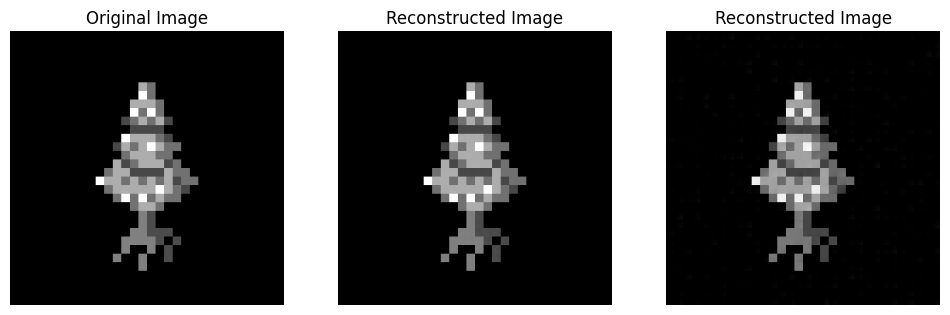

In [129]:
image_path = 'tree_image.png'
block_size = 8
degree = 2

mps_image_encoding(image_path,block_size,degree,layers=1000,opt=False)